![image-2.png](attachment:image-2.png)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle/kaggle (3).json"

In [11]:

%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [12]:
!kaggle datasets download -d puneet6060/intel-image-classification --unzip

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:

!ls

'E:\scientifiic\Programming\Machine Learning Diploma\Computer Vision\George\CV_final_project'
'E:\scientifiic\Programming\Machine Learning Diploma\Computer Vision\George\CV_final_project\models\customized_model.h5'
'E:\scientifiic\Programming\Machine Learning Diploma\Computer Vision\George\CV_final_project\models\customized_model.keras'
 https:
 intel-image-classification.zip
'kaggle (3).json'
 seg_pred
 seg_test
 seg_train


In [14]:
!unzip '/content/drive/MyDrive/kaggle/intel-image-classification.zip' -d '/content/extracted_files'

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/extracted_files/seg_train/seg_train/mountain/7654.jpg  
  inflating: 

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from keras import ops

#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [2]:
os.getcwd()
train_path='/content/extracted_files/seg_train/seg_train'
test_path='/content/extracted_files/seg_test/seg_test'
pred_path='/content/extracted_files/seg_pred/seg_pred'

# Open Folders

now let's first check the Train folder to have a look to its content

In [3]:
# def count_images_in_folders(base_path, description):
#     """
#     Counts and prints the number of images in each folder within the specified base path.

#     Parameters:
#     - base_path: The path containing subfolders with images.
#     - description: A string describing the type of data (e.g., 'training', 'testing', or 'prediction').
#     """
#     for folder in os.listdir(base_path):
#         folder_path = os.path.join(base_path, folder)
#         images = gb.glob(os.path.join(folder_path, '*.jpg'))
#         print(f'For {description} data, found {len(images)} images in folder "{folder}".')

# # Count images in training, testing, and prediction data
# count_images_in_folders(train_path, 'training')
# count_images_in_folders(test_path, 'testing')
# count_images_in_folders(pred_path, 'prediction')

#Checking Images
now we need to heck the images sizes , to know ow they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [4]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

In [5]:

# def get_image_sizes(image_path, is_subfolder=False):

#     """
#     This function calculates the sizes of images in the given path.

#     Parameters:
#     - image_path: Path where images are stored.
#     - is_subfolder: Set to True if the images are in subfolders (like train/test sets).

#     Returns:
#     - A pandas Series with the count of each image size.
#     """
#     sizes = []

#     if is_subfolder:
#         for folder in os.listdir(image_path):
#             images = gb.glob(pathname=str(image_path + '/' + folder + '/*.jpg'))
#             for img in images:
#                 image = plt.imread(img)
#                 sizes.append(image.shape)
#     else:
#         files = gb.glob(pathname=str(image_path + '/*.jpg'))
#         for file in files:
#             image = plt.imread(file)
#             sizes.append(image.shape)

#     return pd.Series(sizes).value_counts()

# # Usage examples
# train_sizes = get_image_sizes(train_path, is_subfolder=True)
# test_sizes = get_image_sizes(test_path, is_subfolder=True)
# pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

# print("Train Image Sizes:\n", train_sizes)
# print("Test Image Sizes:\n", test_sizes)
# print("Prediction Image Sizes:\n", pred_sizes)

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [15]:
def load_images(image_path, code, resize_shape=(150, 150), is_subfolder=True):
    """
    Loads and resizes images from the specified path.

    Parameters:
    - image_path: Path where images are stored.
    - code: A dictionary mapping folder names to labels.
    - resize_shape: Tuple specifying the new size for resizing images (default is (100, 100)).
    - is_subfolder: Boolean indicating if images are in subfolders (True for train/test, False for prediction).

    Returns:
    - x_data: A NumPy array of resized images.
    - y_data: Corresponding labels (if applicable, else returns None for prediction data).
    """
    x_data = []
    y_data = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            folder_path = os.path.join(image_path, folder)
            images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
            for img_path in images:
                image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images
                image_resized = cv2.resize(image, resize_shape)
                x_data.append(image_resized)
                y_data.append(code[folder])  # Append the folder's label
    else:
        images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
        for img_path in images:
            image = cv2.imread(img_path)
            image_resized = cv2.resize(image, resize_shape)
            x_data.append(image_resized)
        y_data = None  # No labels for prediction data

    return np.array(x_data), np.array(y_data)

# Usage for train data
x_train, y_train = load_images(train_path, code, resize_shape=(150, 150), is_subfolder=True)

# Usage for test data
x_test, y_test = load_images(test_path, code, resize_shape=(150, 150), is_subfolder=True)

# Usage for prediction data (no labels)
x_pred, _ = load_images(pred_path, code=None, resize_shape=(150, 150), is_subfolder=False)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_pred shape: {x_pred.shape}")

x_train shape: (14034, 150, 150, 3), y_train shape: (14034,)
x_test shape: (3000, 150, 150, 3), y_test shape: (3000,)
x_pred shape: (7301, 150, 150, 3)


In [ ]:
#implement same as vgg16
customized_model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(100, activation='relu', kernel_size=(3,3), padding='same', input_shape=(150,150,3)),
    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(16, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(100, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(100, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(16, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(100, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [25]:
customized_model = tf.keras.models.load_model("/content/drive/MyDrive/models/customized_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
customized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


NameError: name 'customized_model' is not defined

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# y_train = to_categorical(y_train, num_classes=6)
# y_test = to_categorical(y_test, num_classes=6)
# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0
)
val_scale = ImageDataGenerator(rescale = 1.0/255.0)
val_test = val_scale.flow(
    x_test,
    y_test,
    batch_size=32
)


In [16]:

# Define the path where you want to save the best model
model_save_path = 'E:\scientifiic\Programming\Machine Learning Diploma\Computer Vision\George\CV_final_project/model_weights/best_model.keras'  # Specify your desired path and filename

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)

#early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Minimum learning rate
    verbose=1  # Verbosity mode
)

# Train the model with the ModelCheckpoint callback
model = customized_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=val_test,  # Make sure to include validation data


    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint, reduce_lr]  # Pass the checkpoint callback here
)

customized_model.save("/content/drive/MyDrive/models/customized_model.h5")
customized_model.save("/content/drive/MyDrive/models/customized_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8829 - loss: 0.3237
Epoch 1: val_loss improved from inf to 0.40402, saving model to E:\scientifiic\Programming\Machine Learning Diploma\Computer Vision\George\CV_final_project/model_weights/best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 154s 579ms/step - accuracy: 0.8829 - loss: 0.3237 - val_accuracy: 0.8563 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8884 - loss: 0.3035
Epoch 2: val_loss did not improve from 0.40402
220/220 ━━━━━━━━━━━━━━━━━━━━ 111s 502ms/step - accuracy: 0.8884 - loss: 0.3035 - val_accuracy: 0.7717 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8897 - loss: 0.3053
Epoch 3: val_loss did not improve from 0.40402
220/220 ━━━━━━━━━━━━━━━━━━━━ 109s 497ms/step - accuracy: 0.8897 - loss: 0.3053 - val_accuracy: 0.8520 - val_loss: 0.4788 - learning_rate: 0.0010
Epoch 4/10
220/220 ━

In [ ]:
# Define the chunk size (number of images to process at a time)
chunk_size = 500  # Adjust this based on your memory availability

# Initialize an empty array to store the normalized data
normalized_x_test = np.zeros_like(x_test, dtype=np.float32)

# Normalize in chunks
for i in range(0, len(x_test), chunk_size):
    chunk = x_test[i:i + chunk_size]  # Get a chunk of the data
    normalized_x_test[i:i + chunk_size] = chunk / 255.0  # Normalize the chunk

In [29]:
normalized_x_pred = np.zeros_like(x_pred, dtype=np.float32)

# Normalize in chunks
for i in range(0, len(x_pred), chunk_size):
    chunk = x_pred[i:i + chunk_size]  # Get a chunk of the data
    normalized_x_pred[i:i + chunk_size] = chunk / 255.0  # Normalize the chunk

In [26]:

loss,accuracy=customized_model.evaluate(normalized_x_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 502s 5s/step - accuracy: 0.8738 - loss: 0.3719


In [27]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 0.5206310153007507
accuracy is 0.8153333067893982


In [30]:
y_result = customized_model.predict(normalized_x_pred)

y_result

229/229 ━━━━━━━━━━━━━━━━━━━━ 1220s 5s/step


array([[3.69652063e-01, 7.35607347e-04, 2.18857862e-02, 2.49169650e-04,
        6.05484664e-01, 1.99268153e-03],
       [3.34284693e-01, 2.58324394e-06, 3.45121429e-04, 7.88948626e-07,
        5.41221607e-06, 6.65361404e-01],
       [9.99982238e-01, 3.16985715e-10, 1.90178855e-06, 1.17930767e-08,
        1.17481305e-08, 1.58300136e-05],
       ...,
       [1.06719341e-02, 7.62891650e-05, 8.70186806e-01, 1.07630052e-01,
        1.10880267e-02, 3.46940447e-04],
       [2.44483873e-01, 5.01056900e-04, 5.97845647e-04, 3.03838846e-07,
        1.92892985e-05, 7.54397631e-01],
       [1.85349606e-07, 9.99999285e-01, 5.21281834e-07, 2.89037988e-10,
        1.27790811e-09, 1.97420018e-08]], dtype=float32)

In [31]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result[i])))

In [32]:
y_pred = customized_model.predict(normalized_x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

labels = list(code.values())
target_names = list(code.keys())
report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, labels=labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step
              precision    recall  f1-score   support

   buildings       0.58      0.99      0.73       437
      forest       0.98      0.94      0.96       474
     glacier       0.85      0.81      0.83       553
    mountain       0.80      0.85      0.82       525
         sea       0.94      0.80      0.86       510
      street       0.95      0.54      0.69       501

    accuracy                           0.82      3000
   macro avg       0.85      0.82      0.82      3000
weighted avg       0.85      0.82      0.82      3000

              precision    recall  f1-score   support

   buildings       0.58      0.99      0.73       437
      forest       0.98      0.94      0.96       474
     glacier       0.85      0.81      0.83       553
    mountain       0.80      0.85      0.82       525
         sea       0.94      0.80      0.86       510
      street       0.95      0.54      0.69       501

    accuracy                         

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

num_classes = 6
xx_train = x_train
xx_test = x_test
yy_train = to_categorical(y_train, num_classes=num_classes)
yy_test = to_categorical(y_test, num_classes=num_classes)

train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      brightness_range=[0.8, 1.2],
      channel_shift_range=20.0
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
train_generator = train_datagen.flow(
    xx_train,
    yy_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    xx_test,
    yy_test,
    batch_size=32
)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def vgg16_architecture(num_classes=6):
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(150, 150, 3))

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(2048, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(num_classes, activation='softmax')(x)

    VGG16_model = Model(inputs=base_model.input, outputs=output)

    VGG16_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG16_model

In [ ]:
def vgg19_architecture():
    from keras.applications import VGG19
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(150, 150, 3))
    from keras.layers import BatchNormalization, Dropout

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.50)(x)

    x = Dense(2048, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(6, activation='softmax')(x)

    VGG19_model = Model(inputs=base_model.input, outputs=output)

    VGG19_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG19_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG19_model

In [ ]:
from keras.applications import ResNet152V2
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

def resnet152v2_architecture():
    # Load the base model
    base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(150, 150, 3))

    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers:  # Unfreeze the last 10 layers
       layer.trainable = True

    # Build the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Adjusted dropout rate

    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(6, activation='softmax')(x)

    # Create the model
    ResNet152V2_model = Model(inputs=base_model.input, outputs=output)

    # Print the model summary
    ResNet152V2_model.summary()

    # Compile the model
    optimizer = Adam()
    ResNet152V2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return ResNet152V2_model



# Example of how to train the model
# Assuming you have train_generator and val_generator defined
ResNet152V2_model = resnet152v2_architecture()


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 38, 38, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 38, 38, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 40, 40, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 65,176,582 (248.63 MB)

 Trainable params: 65,021,574 (248.04 MB)

 Non-trainable params: 155,008 (605.50 KB)

In [ ]:
def inception_v3_architecture():
    from keras.applications import InceptionV3

    from keras.layers import BatchNormalization, Dropout

    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(150, 150, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(6, activation='softmax')(x)

    InceptionV3_model = Model(inputs=base_model.input, outputs=output)

    InceptionV3_model.summary()

    optimizer = Adam(learning_rate=0.001)
    InceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return InceptionV3_model

In [7]:
def evaluate_model(model, xx_test, yy_test):
    loss, accuracy = model.evaluate(xx_test, yy_test)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return loss, accuracy

    # cm = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:")
    # print(cm)

    # cr = classification_report(y_true, y_pred, target_names=[f'class_{i}' for i in range(3)])
    # print("Classification Report:")
    # print(cr)

    # return cm, cr




In [20]:
VGG16_model = tf.keras.models.load_model("/content/drive/MyDrive/models/VGG16.keras")
VGG19_model = tf.keras.models.load_model("/content/drive/MyDrive/models/VGG19.keras")
#ResNet152V2_model = tf.keras.models.load_model("/content/drive/MyDrive/models/ResNet152V2_model.keras")
InceptionV3_model = tf.keras.models.load_model("/content/drive/MyDrive/models/InceptionV3_model.keras")

In [10]:
# models = {
#      "VGG16": vgg16_architecture,
#      "VGG19": vgg19_architecture,
#      #"ResNet152V2": resnet152v2_architecture,
#      #"InceptionV3": inception_v3_architecture
# }

# for model_name, model_func in models.items():
# print(f"Training {VGG16_model}...")
# #model = model_func()
# VGG16_model.fit(
# train_generator,
# validation_data=val_generator,
# epochs=5  # Adjust epochs as needed
# )

# # Save the model after training
# VGG16_model.save("/content/drive/MyDrive/models/VGG16.h5")
# VGG16_model.save("/content/drive/MyDrive/models/VGG16.keras")

# print(f"Evaluating {VGG16_model}...")
# loss, accuracy = evaluate_model(VGG16_model, xx_test, yy_test)
# print(f"{VGG16_model} evaluation complete.")
# print(f"Accuracy: {accuracy}\n")
# print("_______________________________________________________________________")

# print(f"Training {VGG19_model}...")
# #model = model_func()
# VGG19_model.fit(
# train_generator,
# validation_data=val_generator,
# epochs=5  # Adjust epochs as needed
# )

#     # Save the model after training
# VGG19_model.save("/content/drive/MyDrive/models/VGG19.h5")
# VGG19_model.save("/content/drive/MyDrive/models/VGG19.keras")

# print(f"Evaluating {VGG19_model}...")
# loss, accuracy = evaluate_model(VGG19_model, xx_test, yy_test)
# print(f"{VGG19_model} evaluation complete.")
# print(f"Accuracy: {accuracy}\n")
# print("_______________________________________________________________________")

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# print(f"Training {ResNet152V2_model}...")
# #model = model_func()
ResNet152V2_model.fit(
train_generator,
validation_data=val_generator,
epochs=10,
callbacks=[reduce_lr]# Adjust epochs as needed
)

    # Save the model after training
ResNet152V2_model.save("/content/drive/MyDrive/models/ResNet152V2_model.h5")
ResNet152V2_model.save("/content/drive/MyDrive/models/ResNet152V2_model.keras")

# print(f"Evaluating {ResNet152V2_model}...")
# loss, accuracy = evaluate_model(ResNet152V2_model, xx_test, yy_test)
# print(f"{ResNet152V2_model} evaluation complete.")
# print(f"Accuracy: {accuracy}\n")
# print("_______________________________________________________________________")


#InceptionV3_model = inception_v3_architecture()
# print(f"Training {InceptionV3_model}...")
# #model = model_func()
# InceptionV3_model.fit(
# train_generator,
# validation_data=val_generator,
# epochs=5,
# #callbacks=[reduce_lr]# Adjust epochs as needed
# )

#     # Save the model after training
# InceptionV3_model.save("/content/drive/MyDrive/models/InceptionV3_model.h5")
# InceptionV3_model.save("/content/drive/MyDrive/models/InceptionV3_model.keras")

# print(f"Evaluating {InceptionV3_model}...")
# loss, accuracy = evaluate_model(InceptionV3_model, xx_test, yy_test)
# print(f"{InceptionV3_model} evaluation complete.")
# print(f"Accuracy: {accuracy}\n")
# print("_______________________________________________________________________")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 374s 571ms/step - accuracy: 0.8293 - loss: 0.4863 - val_accuracy: 0.7907 - val_loss: 2.7126 - learning_rate: 2.5000e-04
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 189s 430ms/step - accuracy: 0.8452 - loss: 0.4553 - val_accuracy: 0.8753 - val_loss: 3.3242 - learning_rate: 2.5000e-04
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 199s 453ms/step - accuracy: 0.8505 - loss: 0.4416 - val_accuracy: 0.8583 - val_loss: 0.6629 - learning_rate: 2.5000e-04
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 189s 431ms/step - accuracy: 0.8460 - loss: 0.4313 - val_accuracy: 0.8867 - val_loss: 3.2844 - learning_rate: 2.5000e-04
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 190s 431ms/step - accuracy: 0.8482 - loss: 0.4349 - val_accuracy: 0.8807 - val_loss: 6.0547 - learning_rate: 2.5000e-04
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 199s 453ms/step - accuracy: 0.8474 - loss: 0.4353 - val_accuracy: 0.7863 - val_loss: 0.6385 - learning_rate: 2.5000e-04
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
print(f"Evaluating {ResNet152V2_model}...")
loss, accuracy = evaluate_model(ResNet152V2_model, xx_test/255.0, yy_test)
print(f"{ResNet152V2_model} evaluation complete.")
print(f"Accuracy: {accuracy}\n")
print("_______________________________________________________________________")


Evaluating <Functional name=functional, built=True>...
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.8557 - loss: 5.1982
Loss: 7.347944736480713
Accuracy: 0.8943333625793457
<Functional name=functional, built=True> evaluation complete.
Accuracy: 0.8943333625793457

_______________________________________________________________________


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, normalized_x_test, y_test):
    # Generate predictions
    y_pred = model.predict(normalized_x_test)

    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score


94/94 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step
y_pred shape: (3000, 6)
y_test shape: (3000,)
y_pred_classes shape: (3000,)


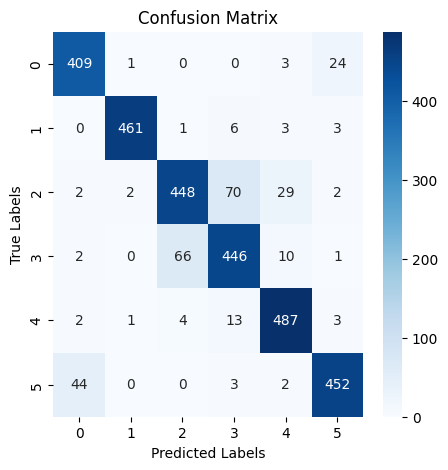

Classification Report:
              precision    recall  f1-score   support

     class_0       0.89      0.94      0.91       437
     class_1       0.99      0.97      0.98       474
     class_2       0.86      0.81      0.84       553
     class_3       0.83      0.85      0.84       525
     class_4       0.91      0.95      0.93       510
     class_5       0.93      0.90      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Precision: 0.9013
Recall: 0.9010
F1-score: 0.9008


(array([[409,   1,   0,   0,   3,  24],
        [  0, 461,   1,   6,   3,   3],
        [  2,   2, 448,  70,  29,   2],
        [  2,   0,  66, 446,  10,   1],
        [  2,   1,   4,  13, 487,   3],
        [ 44,   0,   0,   3,   2, 452]]),
 '              precision    recall  f1-score   support\n\n     class_0       0.89      0.94      0.91       437\n     class_1       0.99      0.97      0.98       474\n     class_2       0.86      0.81      0.84       553\n     class_3       0.83      0.85      0.84       525\n     class_4       0.91      0.95      0.93       510\n     class_5       0.93      0.90      0.92       501\n\n    accuracy                           0.90      3000\n   macro avg       0.90      0.90      0.90      3000\nweighted avg       0.90      0.90      0.90      3000\n',
 0.9013048634939296,
 0.901,
 0.9007566612495059)

In [23]:
generate_confusion_matrix_and_metrics(InceptionV3_model, normalized_x_test, y_test)

## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |          |        |           |          |
| VGG16            |          |        |           |          |
| VGG19            |          |        |           |          |
| Inception_V3     |          |        |           |          |
| RasNet152V2      |          |        |           |          |
| DenseNet         |          |        |           |          |


# Experimental Results